<a href="https://colab.research.google.com/github/raurica/Image-Forgery/blob/main/Project_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition Project

В этом проекте вы познакомитесь с задачей распознавания лиц, узнаете, как ее решать, и построите свой пайплан для решения этой задачи.

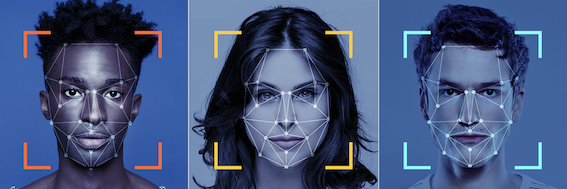

Для начала познакомимся с тем, как работает стандартный пайплан для распознавания лиц. Это не одна нейросеть, которая делает всю работу: это целых три отдельных стадии. После этого в разделе "задача проекта" расписано то, что нужно/можно делать в рамках этого проекта. **Пожалуйста, перед началом работы по проекту внимательно прочитайте раздел "задача проекта"!**

Ну а перед этим всем лучше разберемся с тем, какую задачу вообще мы хотим решать.

## Постановка задачи

Допустим, вы владеете компанией и хотите разработать систему распознавания лиц, чтобы применять ее в своем офисе. Например, чтобы ваши сотрудники могли сканировать лицо вместо прикладывания id карточек к турникетам при входе. Или для обеспечения безопасности в офисах (да, вы — хороший владелец компании, и используете face recognition только для обеспечения безопасности. Никакие данные не собираете, нигде долго не храните и никуда не передаете)  

Получается, вам нужна система, которая может принимать на вход видео, полученное с камер наблюдения, и на выходе выдавать, что за люди были замечены на этом видео. Ваша система должна уметь работать в случаях, когда лица людей запечатлены крупным или мелким планом, когда они чуть повернуты или наклонены, и когда на одном кадре с камеры находятся несколько лиц людей.

Вот решением такой задачи мы сейчас и займемся.

## Пайплайн для распознавания лиц, его обучение и тест

В этой части описано устройство пайплайна для распознавания лиц, а также принцип его обучения и тестирования.

### Пайплайн распознавания лиц

Обычно система распознавания лиц состоит из трех элементов:

- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).

Давайте обсудим все этапы подробнее:

#### Детекция лиц

Пусть мы получили кадр с камеры наблюдения, на котором мы хотим распознать лица. Этот кадр может выглядеть как-то так:

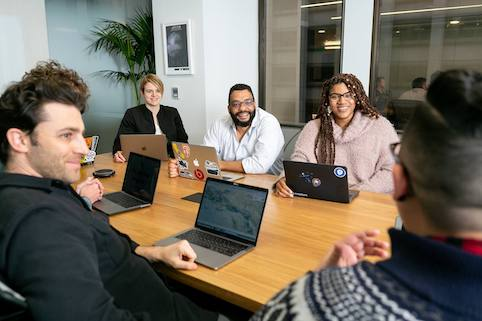

Первый этап обработки фото — детекция лиц на нем. Результат детекции может выглядеть примерно так:

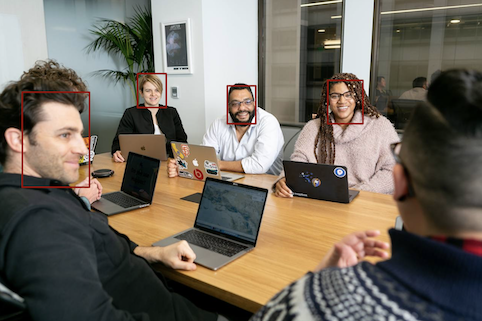

Для детекции лиц на фото может использоваться модель (например, нейросеть), обученная на задачу детекции лиц людей.

#### Выравнивание лиц


После этапа детекции работа с каждым детектированным лицом идет по отдельности
(точнее, с bounding box'ами каждого детектированного лица).

Второй этап — выравнивание лица. Он состоит из двух этапов:
1. На картинке ищутся ключевые точки лица (обычно это координаты зрачков глаз, кончик носа и точки вокруг рта). Для этой задачи используется отдельная модель (возможно, тоже нейросеть). У PyTorch есть [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) с кодом и описанием того, как подобная модель работает;
2. Повернуть и растянуть изображение так, чтобы точки глаз лица лежали на заданной горизонтальной линии, и чтобы между зрачками глаз было определенное расстояние.

Вот так это может выглядеть:

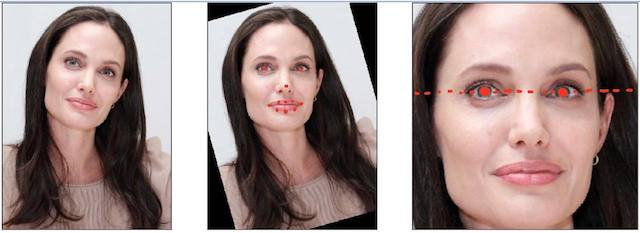

Таким образом, после второго этапа лица выглядят как-то так:

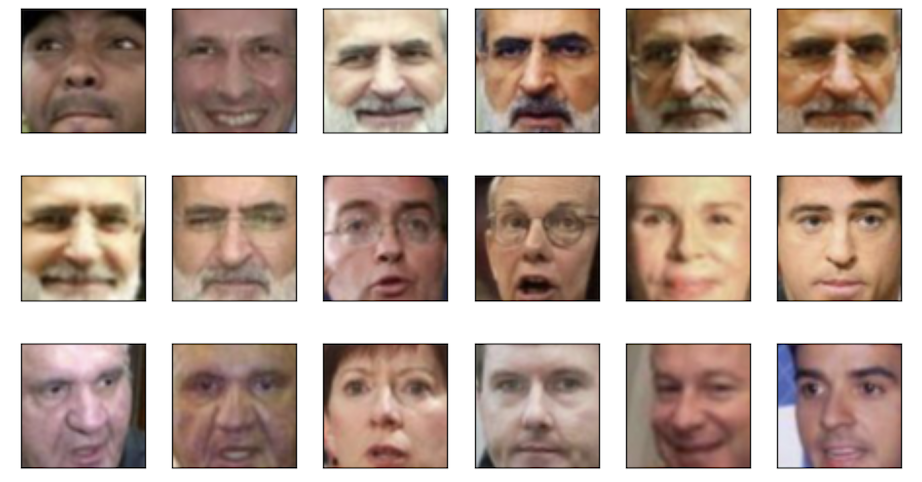

На таких картинках лиц и будет работать третья часть пайплайна — нейросеть, которая распознает лица.

**Зачем нужна стадия выравнивания**: выравнивание лиц датасета делает задачу распознавания лиц проще для модели на третьей стадии пайплайна. Если у всех лиц, которые принимает на вход модель, примерно одинаковый размер и все ключевые части (глаза, нос, рот) находятся в примерно одинаковых местах, это упрощает модели задачу понимания того, что за человек изображен на картинке. Модели не нужно "искать" глаза, рот и т.п. на картинке.

Практика подтверждает, что это сильно улучшает эффективность модели: без стадии выравнивания практически невозможно обучить хорошую систему распознавания лиц. Точнее, возможно, но только если есть очень-очень-очень много обучающих данных. Больше, чем практически у всех даже больших компаний.

#### Распознавание лиц

##### Пояснение

Третья часть пайплайна — это, собственно, распознавание лиц.

Что такое "распознавание": мы хотим построить такую нейросеть, которая принимает на вход картинку лица, а выдает вектор определенного размера. И мы хотим, чтобы векторы лиц одного и того же человека были близки по некоторому расстоянию (например, косинусному), а векторы лиц разных людей были далеки по этому же расстоянию. Обычно в качестве расстояния используется [косинусное расстояние](https://en.wikipedia.org/wiki/Cosine_similarity) (cosine distance).

Почему мы хотим построить именно такую сеть? Почему не посмтроить обычную сеть для классификации и научить ее классифицировать лица из обучающей выборки, где каждый отдельный человек — это один класс? Ответ такой — мы хотим, чтобы наша модель умела работать с лицами людей, которых нет в обучающей выборке. Хотим, чтобы она на лица одного и того же незнакомого человека выдавала близкие векторы (т.е. "говорила" нам, что это один и тот же человек), а на лица разных людей — далекие векторы.

Пусть тогда у нас есть база данных людей вида (id, набор векторов его лиц). Когда к нам придет новая картинка лица, мы ее прогоним через модель и получим вектор этого лица. Далее сравним этот вектор по метрике расстояния с векторами из нашей базы. Тот id, чьи векторы будут наиболее близки к нашему, и будет ответом на вопрос "кто изображен на картинке"



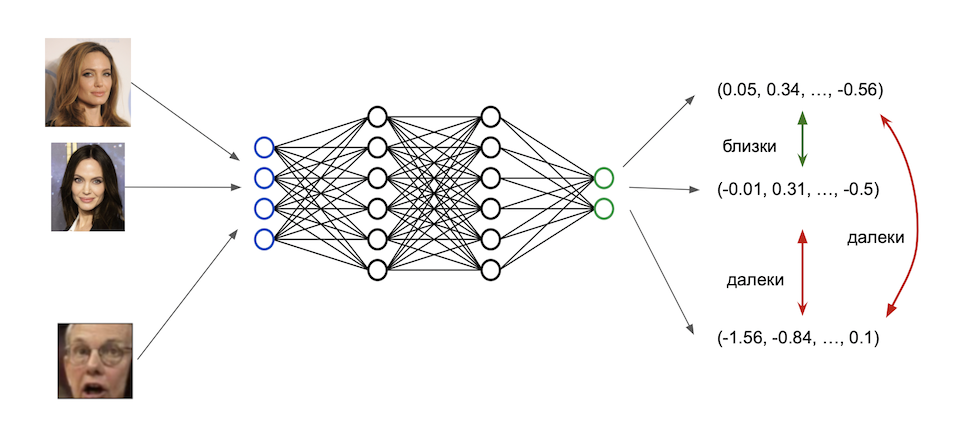

Такую сеть можно обучать разными способами. Два самых распространенных — такие:

1. Можно обучить нейросеть на обучающей выборке лиц на задачу классификации. Каждый отдельный человек — это один класс. В качестве лосс-функции можно использовать стандартную кросс-энтропию или специальные ее модификации (разберем ниже в ноутбуке). Затем, после обучения сети, выкинуть последний слой и считать вектором лица выход предпоследнего слоя сети. Это будет работать: полученные таким образом векторы лиц действительно будут близки для лиц одного и того же человека, и далеки для лиц разных людей. Причем это будет работать даже на тех лицах, которые не было в обучающей выборке (при условии, что обучающая выборка достаточно велика).

    У этого подхода есть недостаток: классов в обучающем датасете может быть очень много. Из-за этого последний слой сети станет очень широким. Это сделает обучение сети вычислительно затратным и сложным по памяти. Иногда приходится этот последний слой делить на несколько разных GPU, настолько он бывает большим.
2.  Можно пойти другим путем: обучать сеть напрямую на задачу "выдавать похожие эмбеддинги для лиц одного и того же человека, и далекие эмбеддинги для лиц разных людей". Это называется **contrastive training**.
    
    На каждой итерации обучения тогда происходит следующее:
    - берется картинка лица, к ней выбирается позитивная пара (еще одна картинка лица того же человека) и негативная (картинка лица другого человека). Все три картинки подаются на вход сети, на выходе получаются три вектора. Далее считается расстояние между векторами 1 и 2 и расстояние между векторами 1 и 3. Нейросеть обучается так, чтобы расстояние между векторами 1 и 2 было как можно меньше, а расстояние между векторами 1 и 3 — как можно больше.

    Лосс-функция в этом случае выглядит так:

 $$L = D(anchor, positive) - D(anchor, negative)$$

У contrastive loss тоже есть недостаток: его достаточно сложно настроить (подобрать к нему гиперпараметры).

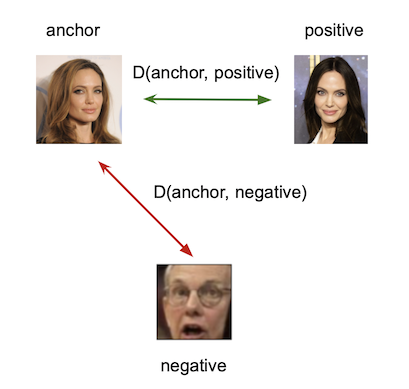

Вот так устроен пайплайн распознавания лиц, который мы хотим получить. Заметим, что все три части пайплайна обучаются отдельно.
- первая часть — это просто задача детекции;
- вторая часть — задача выравнивания фотографии лица;
- третья часть — задача распознавания лица по выровненной фотографии.

подключаем диск и загружаем датасет

#### Решение

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np
import copy
from PIL import Image
from skimage import io, transform
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import lr_scheduler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook, trange
from IPython.display import clear_output
import pandas as pd
import time
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [2]:
TRAIN_NEW = True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# unzip архива
!unzip -q /content/drive/MyDrive/CelebA/celebA_train_500.zip -d celebA_train_500

replace celebA_train_500/celebA_train_500/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
# что есть в этом архиве
! ls celebA_train_500/celebA_train_500

celebA_anno_filtered.txt  celebA_imgs			   celebA_train_split.txt
celebA_anno.txt		  celebA_train_split_filtered.txt


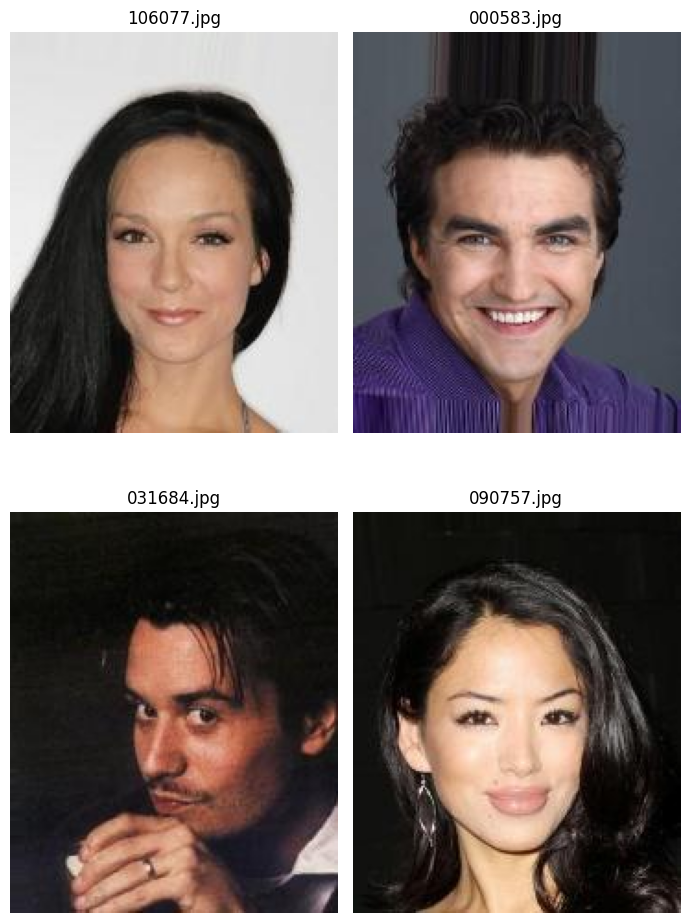

In [6]:
# посмотрим, что это за файлы

img_dir = 'celebA_train_500/celebA_train_500/celebA_imgs/'
img_files = os.listdir(img_dir)

fig, axs = plt.subplots(2, 2, figsize=(7, 10))

for row in range(2):
  for column in range(2):
    name = img_files[random.randint(0, len(img_files))]
    img = mpimg.imread(img_dir + name)
    axs[row, column].imshow(img)
    axs[row, column].axis('off')
    axs[row, column].set_title(name)
plt.tight_layout()
plt.show()

In [7]:
# выкидываем всех у кого мало фоток (<= 14)
# Читаем аннотации
with open('celebA_train_500/celebA_train_500/celebA_anno.txt', 'r') as f:
    lines = f.readlines()

# Парсим аннотации в словарь {имя_файла: метка_человека}
annotations = [x.strip().split() for x in lines]
person_images = {}
for img_name, person_id in annotations:
    if person_id not in person_images:
        person_images[person_id] = []
    person_images[person_id].append(img_name)

# Фильтруем метки с количеством изображений > 14
threshold = 14
filtered_person_images = {person_id: imgs for person_id, imgs in person_images.items() if len(imgs) > threshold}
print(f"Данных сохранено: {len(filtered_person_images)} из {len(person_images)} ({len(filtered_person_images)/len(person_images)*100:.2f}%)")

# Записываем отфильтрованные аннотации в новый файл
with open('celebA_train_500/celebA_train_500/celebA_anno_filtered.txt', 'w') as f:
    for person_id, imgs in filtered_person_images.items():
        for img_name in imgs:
            f.write(f"{img_name} {person_id}\n")


Данных сохранено: 455 из 500 (91.00%)


In [8]:
# Загружаем отфильтрованные аннотации
with open('celebA_train_500/celebA_train_500/celebA_anno_filtered.txt', 'r') as f:
    filtered_annotations = {line.strip().split()[0] for line in f.readlines()}

# Пересоздаем файл разбиения
with open('celebA_train_500/celebA_train_500/celebA_train_split.txt', 'r') as f:
    original_split = f.readlines()

# Оставляем только те строки, где изображение есть в фильтрованных аннотациях
updated_split = []
for line in original_split:
    img_name, split_label = line.strip().split()
    if img_name in filtered_annotations:
        updated_split.append(f"{img_name} {split_label}")

# Записываем обновленный файл
with open('celebA_train_500/celebA_train_500/celebA_train_split_filtered.txt', 'w') as f:
    f.write('\n'.join(updated_split))

In [9]:
# нужно сделать датасет, чтобы с ним было удобно работать
# это функция, на вход которой поступает фотка, а на выходе это какой нибудь np.array в зависимости от лейбла (train/validation/test)
def get_path(dataset_type='train'):
  label_dict = {'train': 0, 'val': 1, 'test': 2}  # в файле celebA_train_split.txt есть пометки во втором столбце, это они

  split = open('celebA_train_500/celebA_train_500/celebA_train_split_filtered.txt', 'r')
  file_split = split.readlines()
  split.close()

  img_path = []
  for row in file_split:
    name, key = row.strip().split()
    if int(key) == label_dict[dataset_type]:
      img_path.append(os.path.join('celebA_train_500/celebA_train_500/celebA_imgs/', name))

  return np.array(img_path)
# теперь мы можем обращаться к соответствующим лейблам датасета

In [10]:
# пишем класс для загрузки изображений и их меток, применения трансформаций/аугментаций (понадобится в обучении модели)
# на вход подаем путь к датасету, трансформации и аугментации
# на выходе будет изображение и его метка (класс)

class celebADataset(Dataset):
  def __init__(self, dataset_type, transform, aug=None):
    self.imgs = get_path(dataset_type=dataset_type)

    anno = open('celebA_train_500/celebA_train_500/celebA_anno_filtered.txt', 'r')
    labels = anno.readlines()
    anno.close()
    labels = {i.strip().split()[0]:int(i.strip().split()[1]) for i in labels}
    self.labels = [labels[x.split('/')[-1]] for x in self.imgs]
    self.transform = transform
    self.aug = aug

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img_name = self.imgs[idx]  # Путь к изображению
    label = self.labels[idx]  # Метка
    img = Image.open(img_name).convert('RGB')  # Приведение к RGB

    # Применяем аугментации, если указаны
    if self.aug:
        img = self.aug(image=np.array(img))['image']
        img = Image.fromarray(img)

    # Применяем трансформации
    img = self.transform(img)

    return img, int(label)

  def get_imgs(self, person_number):
    photos = []
    for i, j in enumerate(self.labels):
      if j == person_number:
        photos.append(self.imgs[i])
    if len(photos) != 0:
      photos = torch.stack([self.transform(Image.open(i)) for i in photos])
    else:
      photos = torch.Tensor()
    return photos

In [11]:
# # ПЕРЕДЕЛАТЬ!
f = open('celebA_train_500/celebA_train_500/celebA_anno_filtered.txt', 'r')
lines = f.readlines()
person = [x.strip().split() for x in lines]
person_images = dict()
for i in person:
  if i[1] not in person_images:
    person_images[i[1]] = []
  person_images[i[1]].append(i[0])

df = pd.DataFrame(data=person_images.items(), columns=['person', 'images'])
df['img_amount'] = df['images'].str.len()
df = df.drop('person', axis=1)
df

,images,img_amount
0,"[000001.jpg, 000404.jpg, 003415.jpg, 004390.jp...",30
1,"[000002.jpg, 011437.jpg, 016335.jpg, 017121.jp...",30
2,"[000003.jpg, 015648.jpg, 033840.jpg, 038887.jp...",30
3,"[000004.jpg, 001778.jpg, 010191.jpg, 013676.jp...",30
4,"[000005.jpg, 008431.jpg, 014427.jpg, 016680.jp...",25
...,...,...
450,"[000515.jpg, 005410.jpg, 020137.jpg, 024989.jp...",20
451,"[000516.jpg, 033078.jpg, 058354.jpg, 059067.jp...",22
452,"[000517.jpg, 001649.jpg, 029332.jpg, 034151.jp...",22
453,"[000518.jpg, 001543.jpg, 003209.jpg, 008966.jp...",30


In [12]:
df['img_amount'].value_counts()

,count
img_amount,
30,181
20,53
29,36
21,27
22,25
25,22
19,21
23,19
24,15


In [13]:
count_30 = (df['img_amount'] < 29).sum()
print(count_30/df['img_amount'].value_counts().sum())


0.5164835164835165


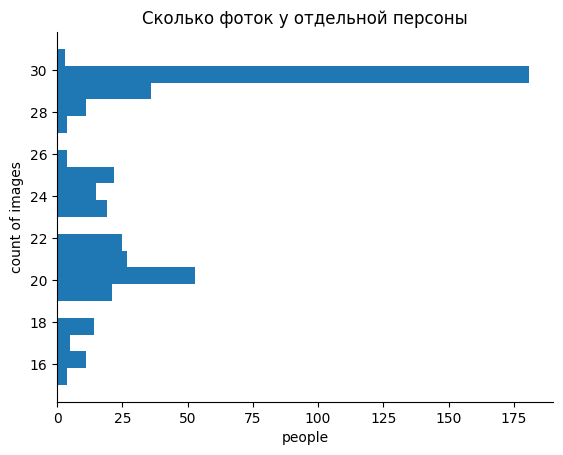

In [14]:
# посмотрим на данные
df['img_amount'].plot(kind='hist', bins=20, title='Сколько фоток у отдельной персоны', orientation='horizontal')
plt.ylabel('count of images')
plt.xlabel('people')
plt.gca().spines[['top', 'right',]].set_visible(False)

видно, что в данных есть дисбаланс, то есть в дате очень много людей с 30-ю фотками, нужно понять что делать с датой

In [15]:
# img_files = df.iloc[random.randint(0, len(df))]['images'][:15]
# img_dir = 'celebA_train_500/celebA_train_500/celebA_imgs/'
# for row in range(15):
#     plt.figure(figsize=(5, 5))
#     name = img_files[row]
#     img = mpimg.imread(img_dir + name)
#     plt.title(name)
#     plt.imshow(img)

In [16]:
transform = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_transform = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.ColorJitter(),
      transforms.RandomHorizontalFlip(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = celebADataset('train', train_transform)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [17]:
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, s=60.0, m=0.30):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        # Инициализация весов
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        # Предвычисления для угловой маржи
        self.register_buffer("cos_m", torch.cos(torch.tensor(self.m)))
        self.register_buffer("sin_m", torch.sin(torch.tensor(self.m)))
        self.register_buffer("th", torch.cos(torch.tensor(torch.pi - self.m)))
        self.register_buffer("mm", torch.sin(torch.tensor(torch.pi - self.m)) * self.m)

    def forward(self, input, label):
        # Нормализация входов и весов
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))

        # Добавление угловой маржи
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        # Создание one-hot представления
        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        # Итоговый выход
        output = one_hot * phi + (1.0 - one_hot) * cosine
        output *= self.s

        return output

In [23]:
from IPython.display import clear_output
def freeze_layers(module):
    for param in module.parameters():
        param.requires_grad = False
def unfreeze_layers(model, num_layers_to_unfreeze):
    layers = list(model.children())
    for layer in layers[-num_layers_to_unfreeze:]:
        for param in layer.parameters():
            param.requires_grad = True

# def train(model, num_epochs, criterion, optimizer, train_loader, val_loader, arcface_layer=None, triplet_criterion=None):
#     # if torch.cuda.is_available():
#     #   torch.cuda.set_device(DEVICE)
#     #   torch.backends.cudnn.benchmark = True

#     #start_time = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         """ Training Phase """
#         model.train()

#         running_loss = 0.
#         running_corrects = 0

#         # load a batch data of images
#         for inputs, labels in train_loader:
#             # Проверка диапазона меток
#             if labels.min() < 0 or labels.max() >= num_classes:
#                 raise ValueError(f"Labels out of range: {labels.min()} - {labels.max()} (num_classes={num_classes})")

#             # # Проверка форм входных данных
#             # print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
#             # print(f"Labels dtype: {labels.dtype}")

#             # inputs = item['image'].to(DEVICE)
#             # labels = item['label'].to(DEVICE)
#             inputs = torch.from_numpy(np.asarray(inputs)).to(DEVICE)
#             labels = torch.from_numpy(np.asarray(labels)).to(DEVICE)

#             # forward inputs and get output
#             optimizer.zero_grad()

#             if arcface_layer is not None:
#               embeddings = model(inputs.to(DEVICE))
#               outputs = arcface_layer(embeddings, labels)
#             else:
#               outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             # get loss value and update the network weights
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(train_data)
#         epoch_acc = running_corrects.double() / len(train_data) * 100.
#         print('[Train Epoch #{}] Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

#         """ Test Phase """
#         model.eval()

#         with torch.no_grad():
#             running_loss = 0.
#             running_corrects = 0

#             for inputs, labels in val_loader:
#                 inputs = torch.from_numpy(np.asarray(inputs)).to(DEVICE)
#                 labels = torch.from_numpy(np.asarray(labels)).to(DEVICE)

#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)

#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(val_data)
#             epoch_acc = running_corrects.double() / len(val_data) * 100.
#             print('[Test Epoch #{}] Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

#         if epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     model.load_state_dict(best_model_wts)

#     return running_loss, running_corrects, model

# def train(model, num_epochs, criterion, optimizer, train_loader, val_loader, arcface_layer=None, triplet_criterion=None):
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         # Замораживаем или размораживаем слои в зависимости от текущей эпохи
#         if epoch == 5:  # Пример: разморозить верхние 2 слоя на 5-й эпохе
#             unfreeze_layers(model, num_layers_to_unfreeze=2)
#             optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)  # Пересоздаем оптимизатор

#         if epoch == 10:  # Пример: разморозить все слои на 10-й эпохе
#             for param in model.parameters():
#                 param.requires_grad = True
#             optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)  # Пересоздаем оптимизатор

#         clear_output(wait=True)

#         """ Training Phase """
#         model.train()

#         running_loss = 0.
#         running_corrects = 0

#         for inputs, labels in train_loader:
#             if labels.min() < 0 or labels.max() >= num_classes:
#                 raise ValueError(f"Labels out of range: {labels.min()} - {labels.max()} (num_classes={num_classes})")

#             inputs = torch.from_numpy(np.asarray(inputs)).to(DEVICE)
#             labels = torch.from_numpy(np.asarray(labels)).to(DEVICE)

#             optimizer.zero_grad()

#             if arcface_layer is not None:
#                 embeddings = model(inputs.to(DEVICE))
#                 outputs = arcface_layer(embeddings, labels)
#             else:
#                 outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)

#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(train_data)
#         epoch_acc = running_corrects.double() / len(train_data) * 100.
#         print('[Train Epoch #{}] Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

#         """ Test Phase """
#         model.eval()

#         with torch.no_grad():
#             running_loss = 0.
#             running_corrects = 0

#             for inputs, labels in val_loader:
#                 inputs = torch.from_numpy(np.asarray(inputs)).to(DEVICE)
#                 labels = torch.from_numpy(np.asarray(labels)).to(DEVICE)

#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)

#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(val_data)
#             epoch_acc = running_corrects.double() / len(val_data) * 100.
#             print('[Test Epoch #{}] Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

#         if epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     model.load_state_dict(best_model_wts)


#     return running_loss, running_corrects, model

def train(
    model, num_epochs, criterion, optimizer, train_loader, val_loader, arcface_layer=None, triplet_criterion=None
):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Замораживаем или размораживаем слои в зависимости от текущей эпохи
        if epoch == 0:  # Заморозить все слои, кроме классификатора
            freeze_layers(model)
            for param in model.fc.parameters():  # Здесь 'fc' – последний слой (зависит от модели)
                param.requires_grad = True
            optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)

        elif epoch == 20:  # Разморозить верхние 2 блока
            unfreeze_layers(model, num_layers_to_unfreeze=2)
            optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)

        elif epoch == 60:  # Разморозить все слои
            for param in model.parameters():
                param.requires_grad = True
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

        # Пересоздаем scheduler при обновлении optimizer
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=5, verbose=True
        )

        """ Training Phase """
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            if arcface_layer:
                embeddings = model(inputs)
                outputs = arcface_layer(embeddings, labels)
            else:
                outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset) * 100.0
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        """ Validation Phase """
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in val_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                if arcface_layer is not None:
                    embeddings = model(inputs)
                    outputs = arcface_layer(embeddings, labels)
                else:
                    outputs = model(inputs)

                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            val_loss = running_loss / len(val_loader.dataset)
            val_acc = running_corrects.double() / len(val_loader.dataset) * 100.0
            val_losses.append(val_loss)
            val_accuracies.append(val_acc.item())

        # Save the best model weights
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"New best model weights saved at epoch {epoch} with accuracy: {best_acc:.4f}")
        scheduler.step(val_loss)

        clear_output(wait=True)
        # Plotting results
        plt.figure(figsize=(12, 5))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy over Epochs')
        plt.legend()
        plt.grid()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
        plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()
        plt.grid()

        plt.show()

        print(f'[Train Epoch #{epoch}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'[Validation Epoch #{epoch}] Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)


    return train_losses, val_losses, train_accuracies, val_accuracies, running_loss, running_corrects, model


In [19]:
df

,images,img_amount
0,"[000001.jpg, 000404.jpg, 003415.jpg, 004390.jp...",30
1,"[000002.jpg, 011437.jpg, 016335.jpg, 017121.jp...",30
2,"[000003.jpg, 015648.jpg, 033840.jpg, 038887.jp...",30
3,"[000004.jpg, 001778.jpg, 010191.jpg, 013676.jp...",30
4,"[000005.jpg, 008431.jpg, 014427.jpg, 016680.jp...",25
...,...,...
450,"[000515.jpg, 005410.jpg, 020137.jpg, 024989.jp...",20
451,"[000516.jpg, 033078.jpg, 058354.jpg, 059067.jp...",22
452,"[000517.jpg, 001649.jpg, 029332.jpg, 034151.jp...",22
453,"[000518.jpg, 001543.jpg, 003209.jpg, 008966.jp...",30


In [20]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
      print('CUDA is not available.  Training on CPU ...')
      DEVICE = torch.device("cpu")
else:
      print('CUDA is available!  Training on GPU ...')
      DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [21]:
unique_labels = set()
for _, labels in train_loader:
    unique_labels.update(labels.numpy())
print(f"Максимальная метка: {max(unique_labels)}")

Максимальная метка: 499


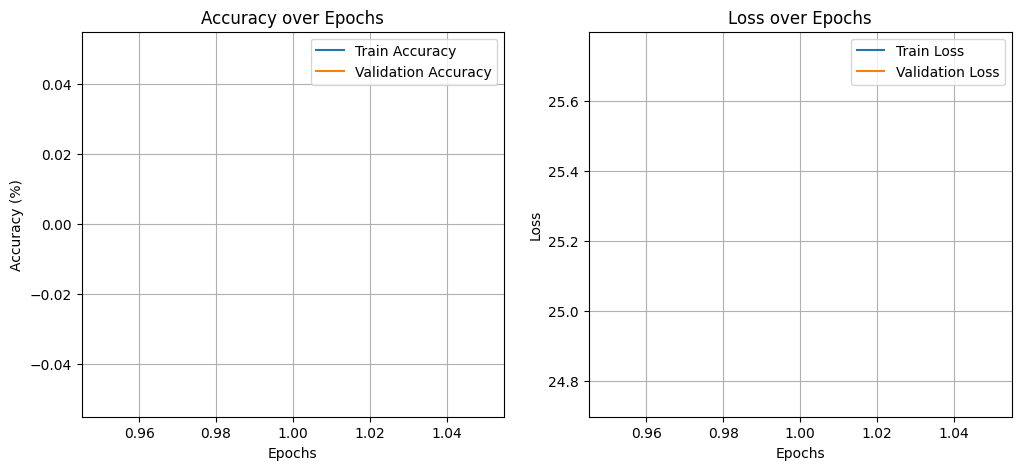

[Train Epoch #0] Loss: 25.7461 Acc: 0.0000
[Validation Epoch #0] Loss: 24.7488 Acc: 0.0000


ValueError: too many values to unpack (expected 3)

In [22]:
# ! git clone https://github.com/timesler/facenet-pytorch.git
# ! mv facenet-pytorch/models ./
! ls models
# from models import inception_resnet_v1
from torchvision.models import resnet50

# def calc_accuracy(model):
#     model.eval()  # testing mode
#     with torch.no_grad():
#         correct = 0
#         for inputs, labels in test_loader:
#             inputs = torch.from_numpy(np.asarray(inputs)).to(DEVICE)
#             logits = model(inputs)
#             classes = np.argmax(logits.cpu().numpy(), axis=1)
#             correct += (labels.numpy() == classes).sum()
#     return correct / len(test_data)

def calc_accuracy(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(inputs)
            _, preds = torch.max(logits, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


if TRAIN_NEW:
  #%env CUDA_LAUNCH_BLOCKING=1

  num_classes = len(set(unique_labels))
  print(f'Количество классов: {num_classes}')

  # model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = num_classes)
  model = resnet50(pretrained=True)
  model.fc = nn.Linear(model.fc.in_features, num_classes)

  model = model.to(DEVICE)

  # model_output_size = model.last_linear.out_features
  model_output_size = model.fc.in_features

  arcface_layer = ArcFaceLoss(in_features=model_output_size, out_features=num_classes)
  arcface_layer = arcface_layer.to(DEVICE)
  # arcface_layer = None

  # freeze_layers(model.conv2d_1a)
  # freeze_layers(model.conv2d_2a)
  # freeze_layers(model.conv2d_2b)
  # freeze_layers(model.maxpool_3a)
  # freeze_layers(model.conv2d_3b)
  # freeze_layers(model.conv2d_4a)
  # freeze_layers(model.conv2d_4b)

  criterion = nn.CrossEntropyLoss()
  # optimizer = optim.AdamW(model.parameters(), lr = 3e-4, weight_decay=1e-4)
  optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4)
  max_epochs = 1

  sure_to_train = int(input('are you sure? \nyes, I am = 1 \nno, it is a mistake = 0\n'))
  if not sure_to_train:
    from IPython.display import display
    print("no sure - no train")
    raise SystemExit("Остановка выполнения этой ячейки.")
  # %%time
  train_losses, val_losses, train_accuracies, val_accuracies, running_loss, running_corrects, model = train(model, max_epochs, criterion, optimizer, train_loader, val_loader, arcface_layer, triplet_criterion=None)
  torch.save(model.state_dict(), 'model_weights.pth')
  print(f'Accuracy = {calc_accuracy(model)}')
else:
  # В другой сессии или после перезапуска
  # model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=1000)  # Создаём ту же архитектуру
  model.load_state_dict(torch.load('/content/drive/MyDrive/CelebA/model_weights.pth', map_location=torch.device('cpu')))
  model.to(DEVICE)

In [28]:
torch.save(model.state_dict(), 'model_CE_weights.pth')

In [ ]:
calc_accuracy(model)

In [ ]:
0.0031466331025802393

accuracy = 0.921334172435494

In [ ]:
model.classify=False

In [ ]:
model.eval()
with torch.no_grad():
    x1 = model(train_data.get_imgs(12).to(DEVICE))
    x2 = model(test_data.get_imgs(12).to(DEVICE))
    x3 = model(test_data.get_imgs(13).to(DEVICE))

In [ ]:
print(cosine_similarity(x1.cpu(), x2.cpu()).mean())
print(cosine_similarity(x1.cpu(), x3.cpu()).mean())

0.86505353
-0.056844123


In [ ]:
0.79078656
-0.011934636

In [ ]:
if TRAIN_NEW:
  number_of_people = 100
  main_result = []
  model.eval()
  with torch.no_grad():
      for i in range(number_of_people):
          print(f'{i+1}/{number_of_people} выполнено')
          results = []
          x1 = model(train_data.get_imgs(i).to(DEVICE))
          for j in range(number_of_people):
              if (len((test_data.get_imgs(j)) != 0)) and (len(train_data.get_imgs(i)) != 0):
                  x2 = model(test_data.get_imgs(j).to(DEVICE))
                  results.append(cosine_similarity(x1.cpu(), x2.cpu()).mean())
              else:
                  results.append(0.0)
          main_result.append(results)
          clear_output(wait=True)
  cosine_df = pd.DataFrame(np.array(main_result))
  cosine_df.to_pickle('cosine_similarity_results.pkl')
else:
  cosine_df = pd.read_pickle('/content/drive/MyDrive/CelebA/cosine_similarity_results.pkl')

100/100 выполнено


In [ ]:
heat_df = cosine_df.copy()
# heat_df[cosine_df < 0.1] = 0

In [ ]:
heat_df.iloc[:5, :5]

,0,1,2,3,4
0,0.983282,0.082191,-0.079740,0.016668,-0.061755
1,0.082731,0.921715,-0.075752,0.048315,-0.069087
2,-0.126710,-0.074540,0.705377,-0.007105,0.040441
3,0.042493,0.032548,-0.010009,0.576727,0.062301
4,-0.070004,-0.043062,0.006853,0.065675,0.658074


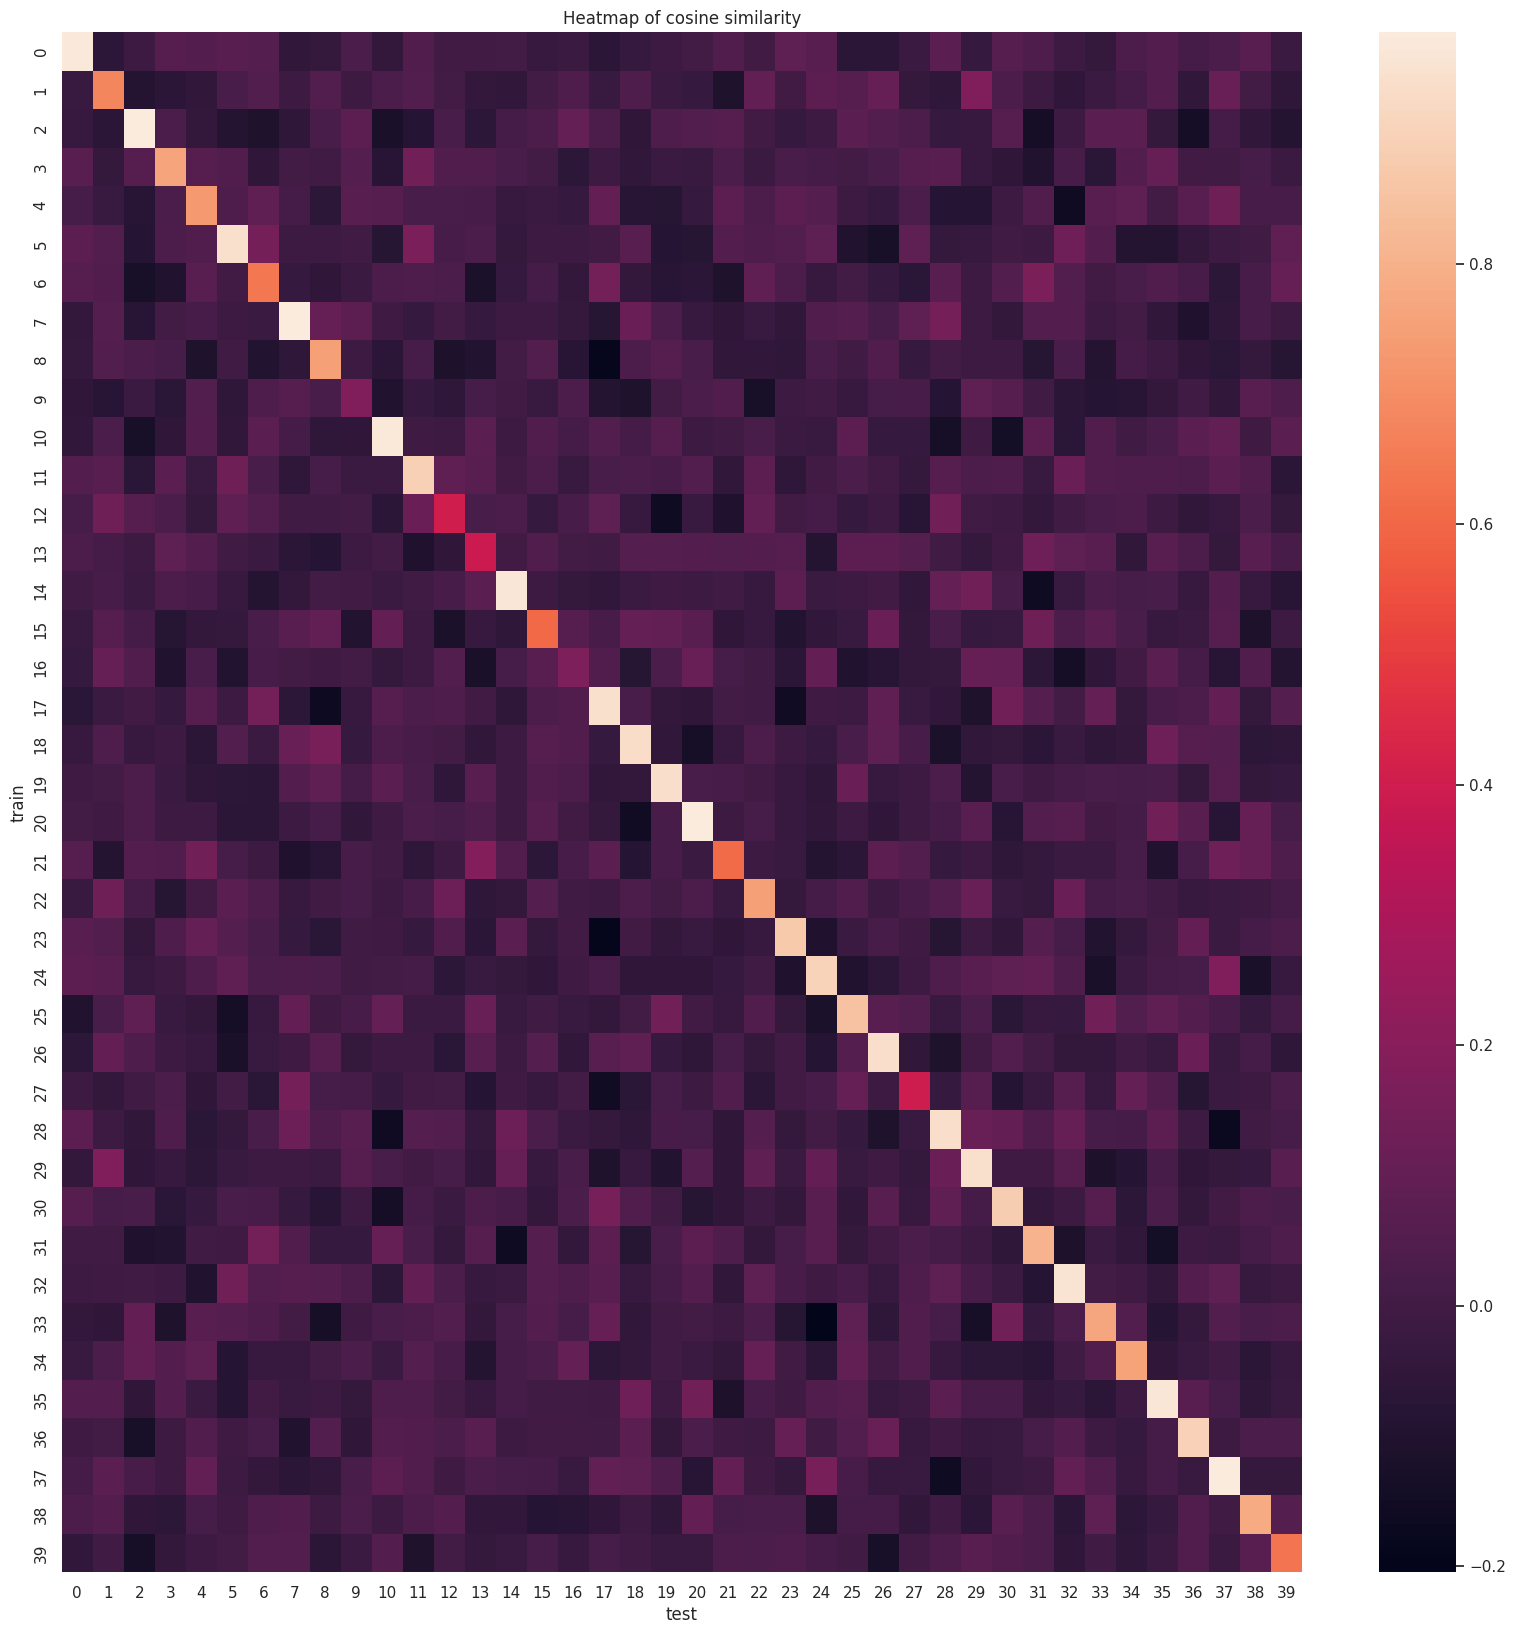

In [ ]:
sns.set(rc={'figure.figsize':(20, 20)})
fig = sns.heatmap(np.array(heat_df.iloc[60:101, 60:101]))
plt.title('Heatmap of cosine similarity')
plt.xlabel('test')
plt.ylabel('train')
plt.show()

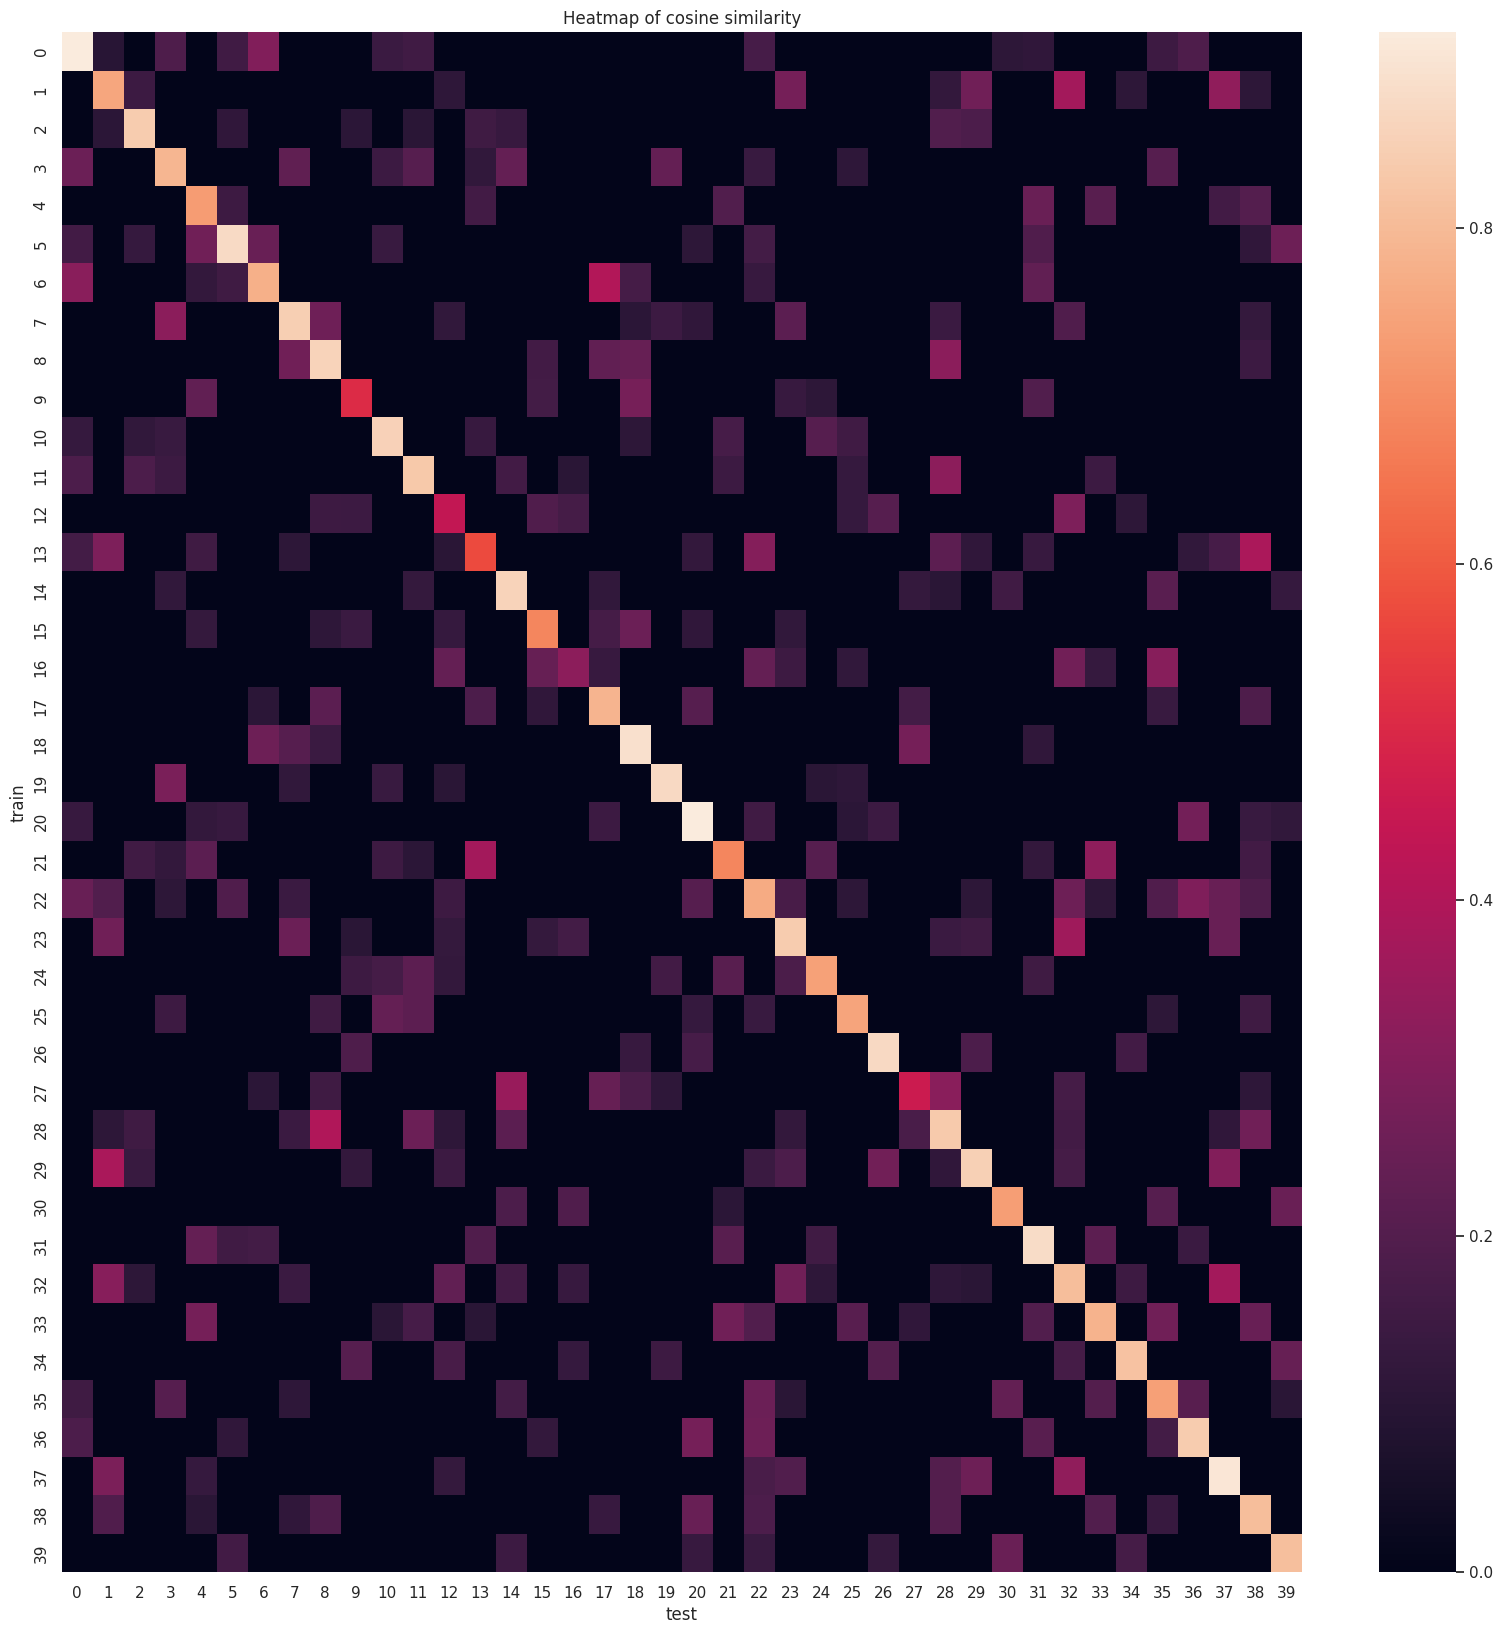

In [ ]:
# img_files = df.iloc[60 + 27]['images'][:15]  # 8 20 25 26 72 76 87
# img_dir = 'celebA_train_500/celebA_train_500/celebA_imgs/'
# for row in range(15):
#     plt.figure(figsize=(5, 5))
#     name = img_files[row]
#     img = mpimg.imread(img_dir + name)
#     plt.title(name)
#     plt.imshow(img)

сходства только если номер человека совпадает - работает хорошо, всего для 7 случаев с номерами (8 20 25 26 72 76 87) результат плох:
- в некоторых случаях для одного человека указаны фото другого человека
- в одном случае представлено мало фотографий в датасете (модель не смогла обучиться для них)
- есть фотографии где человек один и тот же человек просто не похож на себя

тем не менее на 100 человек имеем 7 плохих случаев - это неплохо

### Метрика качества для 3 части пайплайна

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше (*может больше?*), чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

## Шаблон кода для Identificaton rate metric (TPR@FPR)

**Данные**. Если вы обучали нейросеть для распознавания лиц на данных, предложенных в этом ноутбуке (CelebA-500), то для подсчета метрики вы можете воспользоваться данными, которые лежат по этой ссылке: https://disk.yandex.com/d/KN4EEkNKrF_ZXQ. Эти данные уже разбиты на query и distractors, и в отдельном файле также находится информация о классах для картинок из query. Эти картинки заалайнены точно так же, как картинки из обучающей выборки CelebA-500

Если вы обучали нейросеть на других данных, то вам нужно сделать данные для тестирования самому. Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

In [ ]:
# unzip архива
!unzip -q /content/drive/MyDrive/CelebA/celebA_ir.zip -d celebA_ir

In [ ]:
!unzip -q /content/celebA_ir/celebA_ir/celebA_query
!unzip -q /content/celebA_ir/celebA_ir/celebA_distractors

unzip:  cannot find or open /content/celebA_ir/celebA_ir/celebA_query, /content/celebA_ir/celebA_ir/celebA_query.zip or /content/celebA_ir/celebA_ir/celebA_query.ZIP.
unzip:  cannot find or open /content/celebA_ir/celebA_ir/celebA_distractors, /content/celebA_ir/celebA_ir/celebA_distractors.zip or /content/celebA_ir/celebA_ir/celebA_distractors.ZIP.


In [ ]:
# что есть в этом архиве
! ls celebA_ir/celebA_ir

celebA_anno_query.csv  celebA_distractors  celebA_query


In [ ]:
# Если вы работаете с данными, которые даны по ссылке,
# то эта ячейка поможет их загрузить
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('celebA_ir/celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('celebA_ir/celebA_ir/celebA_distractors')

In [ ]:
transform

Compose(
    Resize(size=160, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)

In [ ]:
def compute_embeddings(model, images_list):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  link = ('celebA_ir/celebA_ir/celebA_query/', 'celebA_ir/celebA_ir/celebA_distractors/')
  flac = images_list is distractors_img_names
  data = torch.stack([transform(Image.open(link[flac] + i)) for i in images_list])
  model.to(DEVICE)
  batch_size = 64
  loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)
  if len(images_list):
    model.eval()
    embeddings = []
    with torch.no_grad():
      for i in loader:
        outp = model(i.to(DEVICE))
        embeddings.append(outp.cpu())
    return torch.cat(embeddings)
  else:
    raise NotImplementedError

In [ ]:
query_embeddings = compute_embeddings(model, query_img_names)
distractors_embeddings = compute_embeddings(model, distractors_img_names)

In [ ]:
F.cosine_similarity(query_embeddings[0], query_embeddings[1], dim=0).item()

0.12290773540735245

In [ ]:
from random import choice

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  1. посчитаем косинусные расстояния между лицами, соответствующими одним
     и тем же людям из query части. Например, пусть одному человеку
     соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg.
     Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.

  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
  '''
  cosine_query_pos = []
  for key in query_dict.keys():
    if len(query_dict[key]) > 1:
      for i in range(len(query_dict[key]) - 1):
        index_name_i = query_img_names.index(query_dict[key][i])
        for j in range(i+1, len(query_dict[key])):
          index_name_j = query_img_names.index(query_dict[key][j])
          if type(choice(query_embeddings)) is torch.Tensor:
            cosine_query_pos.append(F.cosine_similarity(query_embeddings[index_name_i], query_embeddings[index_name_j], dim=0).item())
          else:
              cosine_query_pos.append(
    cosine_similarity(
        np.array(query_embeddings[index_name_i]).reshape(1, -1),
        np.array(query_embeddings[index_name_j]).reshape(1, -1)
    )[0][0]
)

  return cosine_query_pos
  raise NotImplementedError

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  '''
  нужно получить желательно список того же размера как и для TP,
  для этого считаем количество комбинаций которое могло было быть для данного ключа,
  но вмесето подстановки значений по данному ключу, берем любое значение по
  несовпадающему ключу
  '''
#   cosine_query_neg = []
#   key_list = list(query_dict.keys())
#   for key in query_dict.keys():
#     key_list = list(query_dict.keys())
#     key_list.remove(key)

#     if len(query_dict[key]) > 1:
#       for i in range(len(query_dict[key])):
#         not_key = choice(key_list)

#         index_name_i = query_img_names.index(query_dict[key][i])
#         index_name_j = query_img_names.index(choice(query_dict[not_key]))

#         if type(choice(query_embeddings)) is torch.Tensor:
#           cosine_query_neg.append(F.cosine_similarity(query_embeddings[index_name_i], query_embeddings[index_name_j], dim=0).item())
#         else:
#           cosine_query_neg.append(
#     cosine_similarity(
#         np.array(query_embeddings[index_name_i]).reshape(1, -1),
#         np.array(query_embeddings[index_name_j]).reshape(1, -1)
#     )[0][0]
# )
  cosine_query_neg = []
  key_list = list(query_dict.keys())
  for k1 in key_list[:-1]:
    if len(query_dict[k1]) > 0:
      for k2 in key_list[key_list.index(k1) + 1:]:
        if len(query_dict[k2]) > 0:
          for i in range(len(query_dict[k1])):
            index_name_i = query_img_names.index(query_dict[k1][i])
            for j in range(len(query_dict[k2])):
              index_name_j = query_img_names.index(query_dict[k2][j])
              if type(choice(query_embeddings)) is torch.Tensor:
                cosine_query_neg.append(F.cosine_similarity(query_embeddings[index_name_i], query_embeddings[index_name_j], dim=0).item())
              else:
                  cosine_query_neg.append(
    cosine_similarity(
        np.array(query_embeddings[index_name_i]).reshape(1, -1),
        np.array(query_embeddings[index_name_j]).reshape(1, -1))[0][0])

  return cosine_query_neg
  raise NotImplementedError

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  cosine_qd = []
  for q in query_embeddings:
    for d in distractors_embeddings:
      if type(choice(query_embeddings)) is torch.Tensor:
        cosine_qd.append(F.cosine_similarity(q, d, dim=0).item())
      else:
        cosine_qd.append(
    cosine_similarity(np.array(q).reshape(1, -1),
        np.array(d).reshape(1, -1))[0][0])


  return cosine_qd
  raise NotImplementedError

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


Ячейка ниже проверяет, что код работает верно:

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

In [ ]:
print(len(test_cosine_query_neg))
print(len(true_cosine_query_neg))

11
11


И, наконец, финальная функция, которая считает IR metric:

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  # false_pairs = cosine_query_neg + cosine_query_distractors
  # N = round(fpr * len(false_pairs))
  # false_pairs.sort()
  # threshold = false_pairs[N]
  # TPR = len([' ' for i in cosine_query_pos if i >= threshold])/len(cosine_query_pos)

  # return threshold, TPR

  cosine_query_pos = torch.Tensor(cosine_query_pos)
  cosine_query_neg = torch.Tensor(cosine_query_neg)
  cosine_query_distractors = torch.Tensor(cosine_query_distractors)

  false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
  N = round(fpr * len(false_pairs))
  false_pairs = torch.sort(false_pairs, descending = True)[0]
  threshold = false_pairs[N]
  TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)
  return threshold.item(), TPR

И ячейки для ее проверки:

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [ ]:
for fpr in [0.75, 0.5, 0.2, 0.1, 0.05, 0.01]:
  threshold, TPR = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,fpr=fpr)
  print(f"fpr = {fpr} \n\tthreshold = {threshold} \n\tTPR = {TPR}\n")

fpr = 0.75 
	threshold = 0.15338978171348572 
	TPR = 0.8887303851640513

fpr = 0.5 
	threshold = 0.24506545066833496 
	TPR = 0.7372461109978942

fpr = 0.2 
	threshold = 0.3640501797199249 
	TPR = 0.4781604510563141

fpr = 0.1 
	threshold = 0.42710909247398376 
	TPR = 0.338835676924122

fpr = 0.05 
	threshold = 0.4795379042625427 
	TPR = 0.24679029957203993

fpr = 0.01 
	threshold = 0.5807533264160156 
	TPR = 0.11480198356089939



In [ ]:
# fpr = 0.75
# 	threshold = 0.37410372495651245
# 	TPR = 0.948237212145914

# fpr = 0.5
# 	threshold = 0.5025955438613892
# 	TPR = 0.8676041029821344

# fpr = 0.2
# 	threshold = 0.6416991353034973
# 	TPR = 0.6667345968344541

# fpr = 0.1
# 	threshold = 0.7011966109275818
# 	TPR = 0.5291080768969499

# fpr = 0.05
# 	threshold = 0.7436498403549194
# 	TPR = 0.40961891175871207

# fpr = 0.01
# 	threshold = 0.8088546991348267
# 	TPR = 0.21988995312818424

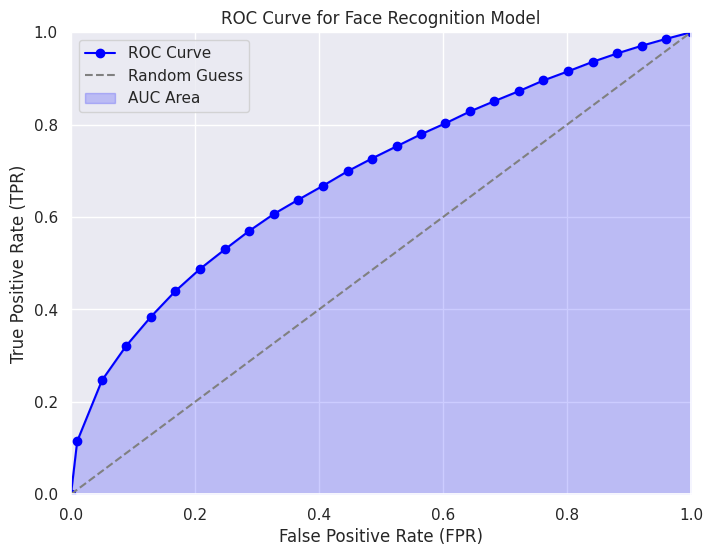

In [ ]:
# fpr_values = [0.75, 0.5, 0.2, 0.1, 0.05, 0.01]
# tpr_values = [0.948237212145914, 0.8676041029821344, 0.6667345968344541, 0.5291080768969499, 0.40961891175871207, 0.21988995312818424]
fpr_values = []
tpr_values = []
n = 25
for i in range(n):
  fpr = round(0.01 + i * (1 - 0.01) / n, 3)
  threshold, TPR = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,fpr=fpr)
  fpr_values.append(fpr)
  tpr_values.append(TPR)
# Построение ROC-кривой
fpr_values = np.concatenate([[0], fpr_values, [1]])
tpr_values = np.concatenate([[0], tpr_values, [1]])
plt.figure(figsize=(8, 6))
plt.plot(fpr_values, tpr_values, marker='o', label='ROC Curve', color='blue')

# Линия "случайного угадывания"
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Закрашиваем область под кривой
plt.fill_between(fpr_values, tpr_values, alpha=0.2, color='blue', label='AUC Area')

# Настройки осей
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Face Recognition Model')
plt.grid(True)
plt.legend()
plt.show()


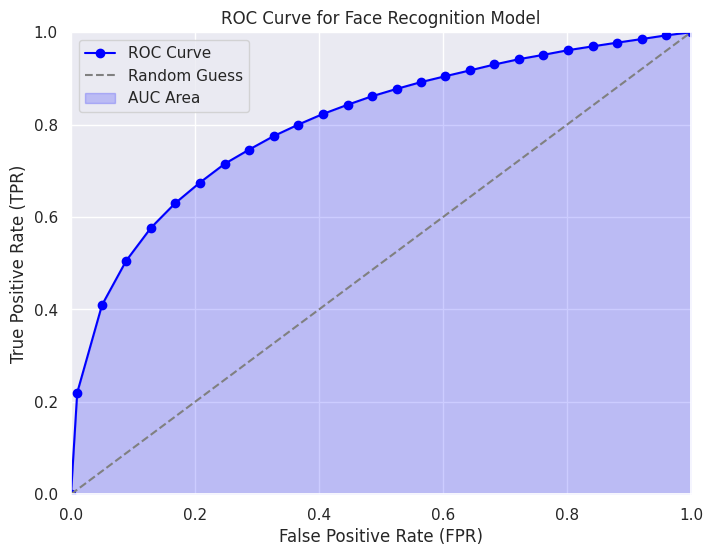

In [ ]:
from sklearn.metrics import auc
auc(fpr_values, tpr_values)

0.6903572447523947

In [ ]:
0.8038488893417567

снижение FPR требует более высокого порога сходства, что снижает общую долю TP. Модель неплоха, но в строгих условиях ей тяжело

### Лосс-функции для 3 части пайплайна

Выше мы поняли, что нейросеть для распознавания лиц можно обучать разными способами. Два, которые мы упомянули — обучение сети на задачу классификации и с помощью contrastive loss. Давайте поговорим о том, какие лосс-функции мы можем использовать в том и в другом случае.



#### ArcFace Loss (Additive Angular Margin Loss)

В случае с обучением на задачу классификации лосс-функция, которая нам приходит в голову — Cross-Entropy. И на нее действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

Репозиторий с кодом: https://github.com/deepinsight/insightface

#### Triplet Loss

Triplet Loss — это один из лоссов для contrastive learning. Чтобы учить модель с помощью этого лосса, модели не нужен последний классификационный слой. Этот лосс работает прямо с эмбеддингами $x_i$ элементов, которые выдает модель.

Снова скажем, что идея лосса — заставить эмбеддинги лиц одного человека быть более близкими по некоторому расстоянию, а эмбеддинги лиц разных людей — далекими друг от друга. Общая формула лосса выглядит так:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

здесь
- $e$ — эмбеддинг входного лица (output модели)
- $p$ — "positive" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были близки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото одного и того же человека).
- $n$ — "negative" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были далеки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото разных людей).
- $d(x, y)$ — метрика расстояния между эмбеддингами, по которой мы их сравниваем.
- margin — гиперпараметр, который заставляет $d(a, p)$ и $d(a, n)$ быть еще дальше друг от друга.

**Эмбеддинги $e$, $p$ и $n$ нужно нормализовать, прежде чем подавать в лосс-функцию**.

У TripletLoss есть куча разных вариаций. В некоторых из них больше гиперпараметров, в других предлагают использовать больше одного позитивного и негативного эмбеддинга за раз. Где-то предлагается умный способ выбора negative эмбеддинга (например, выбирается такой, на котором нейросеть пока плохо работает, т.е. считает $e$ и $n$ близкими).

Пример реализации TripletLoss можно найти [здесь](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss).

Будьте готовы, что TripletLoss придется настраивать, чтобы добиться хорошего результата при обучении сети.


**Что нужно учесть при реализации Triplet Loss**:
- при обучении мы обычно хотим следить за ходом обучения модели, считая какую-то метрику качества. Тут у нас больше нет классификационного слоя, так что accuracy мы считать не можем. Нужно придумать, как в случае Triplet Loss считать метрику качества на вализации в течение обучения. Подумайте, как можно это сделать?
- скорее всего, чтобы обучить сеть на Triplet Loss, придется написать кастомный Dalaset/Dataloader, который будет возвращать тройки элементов (anchor, positive, negative).
- не забудьте нормализовать эмбеддинги перед подсчетом лосса! Это можно сделать руками, а можно, например, добавить в конец сети batchnorm без обучаемых параметров.

**Доплитература по Triplet Loss**:

- Идея TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss
- Хорошая статья про batch mining techniques для выбора positive и negative элементов: https://omoindrot.github.io/triplet-loss#triplet-mining
- Реализация TripletLoss в PyTorch : https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss
- Еще одна реализация TripletLoss: https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py

#### Другие лосс-функции

Кроме ArcFace и Triplet Loss, есть еще много разных вариантов лоссов для задачи face recognition. Некоторые из них можно найти, например, [тут](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w48/Hsu_A_Comprehensive_Study_on_Loss_Functions_for_Cross-Factor_Face_Recognition_CVPRW_2020_paper.pdf). Вы можете попробовать реализовать другие лосс-функции в этом проекте.

Кроме этого, можно миксовать лосс-функции. Например, обучать нейросеть на сумме ArcFace и TripletLoss. Часто так выходит лучше, чем если обучать на каком-то одном лоссе.

## Задача проекта

В целом, **задача проекта — реализовать один или несколько частей системы распознавания лиц**. Вот что можно делать:

- (2 балла, обязательная часть!) Обучить нейросеть для 3 части пайплайна (распознавание лиц) на CE loss. Для этого можно использовать нейросети, предобученные на ImageNet. Нельзя брать нейросети, которые уже предобучены на распознавание лиц! Добиться достаточного качества классификации.
- (2 балла) Обучить нейросеть для поиска ключевых точек лица и написать код, который принимает на вход фотографию лица и возвращает выровненное лицо на основе найденных точек (т.е. **реализовать вторую часть пайплайна face recognition**);
- (2 балла) Собрать весь пайплайн распознавания лиц. Этому пайплайну должно быть можно подать на вход картинку с лицами, и пайплайн должен возвращать эмбеддинги всех найденных лиц. Хорошо будет продемонстрировать работу вашего пайплайна на паре лиц одинаковых и разных людей с подсчетом метрики расстояния между их эмбеддингами. В пайплайне можно использовать предобученную сеть для детекции лиц, или же обучить свою;
- (2 балла) Реализовать Identification Rate Metric (ниже дан щаблон кода для него и ячейки для тестирования);
- (2 балла) Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
- (2 балла) Реализовать Triplet loss, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
- (1 балл) Обучить сеть на смеси ArcFace loss и Triplet loss. Добиться достаточного качества классификации;
- (2 балла) Исследовать литературу, статьи по Face Recognition, написать literature review с обзором современных методов, улучшений сети и пайплайна.
- (2 балла) Исследовать пространство полученных эмбеддингов. Например, как в случае Arcface Loss расположены эмбеддинги на сфере? Где расположены эмбеддинги картинок-аутлаеров? (например, если лицо на картинке сильно смазано или почти не видно. Или это вообще не картинка лица). Как еще можно исследовать модель?
- Улучшить сеть с помощью разных трюков. Например, попробовать другие лосс-функции, поискать статьи с разными улучшениями и попробовать что-то закодить. Баллы тут зависят от сложности улучшения и вашей иреализации.

Пожалуйста, пишите подробные комментарии к своему коду. Вставляйте ссылки на статьи, где нашли какие-то трюки. Объясняйте, почему реализовали что-то именно так. Будет классно, если вы опишете свой путь в экспериментах при работе с оубчением модели или Triplet Loss.


**Данные. Какие данные можно использовать для выполнения проекта:**

Для третьей части пайплайна (нейросети для распознавания лиц) есть такие варианты:
- Я подготовила данные лиц 500 людей CelebA-500. Они уже выровнены. Скачать можно тут: https://disk.yandex.ru/d/S8f03spLIA1wrw
    Внутри:
        - celebA_imgs — папка с выровненными картинками;
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
        - celebA_train_split.txt — файл со сплитом на train/val/test.
    Эти данные — часть открытого датасета [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html), который один из стандартных для обучения моделей, связанных с лицами.
- Использовать любые другие данные. Например, можно взять больше картинок из [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html). Или вот еще один популярный датасет: [LFW](https://colab.research.google.com/corgiredirector?site=http%3A%2F%2Fvis-www.cs.umass.edu%2Flfw%2F). Обращайте внимание на то, выровнены ли лица в том датасете, который вы скачиваете, и кропайте картинки так, чтобы на них оставалось преимущественно лицо.


Может быть удобно сначала проверить вашу сеть на данных CelebA-500, а затем переходить к ее обучению на большем датасете.

Для обучения других частей пайплайна данные нужно выбрать самим. Разные части пайплайна можно обучать на разных данных. Но нужно, чтобы затем весь пайплайн хорошо работал на новых лицах.

- Для тестирования кода Identification Rate Metric я также подготовила данные из CelebA, которые выровнены точно так же, как картинки из CelebA-500. Если вы обучили нейросеть на датасете CelebA-500, можете ее тестировать с помощью этих данных. Ссылка на них есть в разделе "шаблон кода для Identification Rate Metric" ниже в ноутбуке.



**Проект оценивается из 10 баллов. Чтобы проект считался сданным, нужно набрать 5 или более баллов.**  Можно выполнять любые части проекта, которые описаны выше, баллы будут суммироваться. Единственная обязательная часть — обучение сети с нуля на CE loss.

Самый простой (на мой взгляд) набрать 6 баллов:
- (2 балла) Обучить нейросеть для распознавания лиц на датасете CelebA-500. Чтобы получить два балла, нужно добиться accuracy на тестовой части >0.7;
- (2 балла) Реализовать Identification Rate Metric, протестировать ее на предоставленных данных;
- (2 балла) Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться accuracy на тестовой части >0.7;

